In [0]:
#Connect google drive
from google.colab import drive
drive.mount('/content/gdrive')

import json
import zipfile
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import csv
import os
import time
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import helper
from PIL import Image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm


# This will go away in the future.
# If this gives an error, you might be running TensorFlow 2 or above
# If so, the just comment out this line and run this cell again
#tf.enable_eager_execution() 

print("Tensorflow Version: ",tf.__version__)

#Download dataset from kaggle iFood 2019 competition
!wget https://food-x.s3.amazonaws.com/annot.tar
!tar -xf annot.tar
!rm -r annot.tar
!wget https://food-x.s3.amazonaws.com/train.tar
!tar -xf train.tar
!rm -r train.tar
!wget https://food-x.s3.amazonaws.com/val.tar
!tar -xf val.tar
!rm -r val.tar
!wget https://food-x.s3.amazonaws.com/test.tar  
!tar -xf test.tar
!rm -r test.tar

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Tensorflow Version:  1.13.1
--2019-05-31 12:48:36--  https://food-x.s3.amazonaws.com/annot.tar
Resolving food-x.s3.amazonaws.com (food-x.s3.amazonaws.com)... 52.217.1.36
Connecting to food-x.s3.amazonaws.com (food-x.s3.amazonaws.com)|52.217.1.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3123200 (3.0M) [application/x-tar]
Saving to: ‘annot.tar’

annot.tar           100%[===================>]   2.98M  14.6MB/s    in 0.2s    

2019-05-31 12:48:37 (14.6 MB/s) - ‘annot.tar’ saved [3123200/3123200]

--2019-05-31 12:48:42--  https://food-x.s3.amazonaws.com/train.tar
Resolving food-x.s3.amazonaws.com (food-x.s3.amazonaws.com)... 52.216.112.139
Connecting to food-x.s3.amazonaws.com (food-x.s3.amazonaws.com)|52.216.112.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2370519040 (2.2G) [application/x-tar]
Sa

In [0]:
#############################################################
#                                                           #
# Hyperparameters setup and initialization of key variables #
#                                                           #
#############################################################
base_dir = '/content'
train_dir = os.path.join(base_dir, 'train_set')
validation_dir = os.path.join(base_dir, 'val_set')
test_dir = os.path.join(base_dir, 'test_set')


# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "InceptionResNetV2"

#Checkpoint file containing trained weights
checkpoint_file = '/content/gdrive/My Drive/InceptionResNetV2_weights-improvement-08-0.69.hdf5'

# Number of classes in the dataset
num_classes = 251

# Batch size for training (change depending on how much memory you have)
BATCH_SIZE = 128

# Learning rate
learning_rate = 0.01

# Number of epochs to train for
num_epochs = 5

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

# Set the image size (typically 224x224 for most of the models, however for inception it has to be 299x299)
image_size = 299

In [0]:
#Load label to text mapping as well as labels from files to python dictionaries 
#Label mapping (mapping from category label to category name) from text file to a dictionary
cat_to_name = {}
with open("class_list.txt") as f:
    for line in f:
       (key, val) = line.split()
       cat_to_name[int(key)] = val

train_labels = pd.read_csv(os.path.join(base_dir,'train_info.csv'), header=None, dtype=str)
train_labels.columns = ["img_name","label"] # add header
val_labels = pd.read_csv(os.path.join(base_dir,'val_info.csv'), header=None, dtype=str)
val_labels.columns = ["img_name","label"] # add header
test_labels = pd.read_csv(os.path.join(base_dir,'test_info.csv'), header=None, dtype=str)
test_labels.columns = ["img_name"] # add header

In [0]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )
valid_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of batch_size using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(dataframe = train_labels,
                                                    directory = train_dir,
                                                    x_col = 'img_name',
                                                    y_col = 'label',
                                                    class_mode = 'categorical',
                                                    batch_size = BATCH_SIZE,
                                                    target_size = (image_size, image_size)
                                                   )

# Flow validation images in batches of batch_size using valid_datagen generator
validation_generator = valid_datagen.flow_from_dataframe(dataframe = val_labels,
                                                    directory = validation_dir,
                                                    x_col = 'img_name',
                                                    y_col = 'label',
                                                    class_mode = 'categorical',
                                                    batch_size = 1, #can be BATCH_SIZE or canbe set to 1 if you would like to predict for entire dataset
                                                    shuffle = False,
                                                    target_size = (image_size, image_size)
                                                   )
# Flow test images in batches of batch_size using valid_datagen generator
test_generator = test_datagen.flow_from_dataframe(dataframe = test_labels,
                                                   directory = test_dir,
                                                   x_col = 'img_name',
                                                   class_mode = None,
                                                   batch_size = 1,
                                                   shuffle = False,
                                                   target_size = (image_size, image_size)
                                                  )

Found 118475 images belonging to 251 classes.
Found 11994 images belonging to 251 classes.
Found 28377 images.


In [0]:
##############################################
# Transfer learning                          #
#                                            #
##############################################

from tensorflow.keras import layers
from tensorflow.keras import Model

#Download file containing pretrained weights for the selected model
#!wget --no-check-certificate \
#    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

#local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionResNetV2(input_shape = (image_size, image_size, 3), 
                                include_top = True, 
                                weights = 'imagenet') #weights = None means that you have your own file with pretrained weights

#pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
#pre_trained_model.summary()

#Select last layer you want to use from the model
#In this case we select (i.e. mixed7) as the last layer in the model
last_layer = pre_trained_model.get_layer('avg_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Instructions for updating:
Colocations handled automatically by placer.
225214464/225209952 [==============================] - 5s 0us/step
last layer output shape:  (None, 1536)


In [0]:
from tensorflow.keras.optimizers import SGD

# Flatten the output layer to 1 dimension
#x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
#x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate (rate = 1 - keep_prob)
#x = layers.Dropout(rate=0.5)(x)                  
# Add additional 512 hidden layer with relu
#x = layers.Dense  (512, activation='relu')(x)
# Add final classification layer with relu
x = layers.Dense  (num_classes, activation='softmax')(last_output)

model = Model(pre_trained_model.input, x) 

#model.summary()


In [0]:
#below lines is only valid when you want to train on Colab TPUs
#export TPU_NAME=grpc://10.240.1.2:8470 #export environment variable on OS level before running Jupyter Notebook
#TPU_ADDRESS = 'grpc://10.240.1.2:8470' #This is for Google Cloud TPUs only
#tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR'] #This is for colab TPUs only

#tpu_model = tf.contrib.tpu.keras_to_tpu_model(
#    model,
#    strategy=tf.contrib.tpu.TPUDistributionStrategy(
#        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)
#    )
#)


#change from "tpu_model.compile" to "model.compile" of you do not want to use TPUs
#tpu_model.compile(tf.train.MomentumOptimizer(learning_rate=0.001, momentum=0.9),
#                  loss = 'binary_crossentropy',
#                  metrics = ['acc'])

model.compile(optimizer = SGD(lr=learning_rate, momentum=0.9, decay=1e-6), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

# checkpoint
filepath="/content/gdrive/My Drive/ResnetV2_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [0]:
#num_train_examples = train_generator.samples

#Change from "tpu_model" to "model" if you do not want to use TPUs 
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            #steps_per_epoch = np.ceil(num_train_examples/BATCH_SIZE),
            epochs = num_epochs,
            #validation_steps = 50,
            verbose = 1,
            callbacks=callbacks_list
)



In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/gdrive/My Drive/InceptionResNetV2_model.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

In [0]:
!ls /content/gdrive/My\ Drive

In [0]:
# load json and create model
#from keras.models import model_from_json
#json_file = open("/content/gdrive/My Drive/DenseNet-201_model.json", 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)

# load weights into new model
model.load_weights(checkpoint_file)
print("Loaded model from disk")

Loaded model from disk


In [0]:
#Predict the output for validation_generator
#You need to reset the test_generator before whenever you call the predict_generator. 
#This is important, if you forget to reset the test_generator you will get outputs in a weird order.
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()

pred_val=model.predict_generator(validation_generator,
                             use_multiprocessing = False,
                             steps=STEP_SIZE_TEST,
                             verbose=1)


11994/11994 [==============================] - 500s 42ms/step


<Figure size 432x288 with 0 Axes>

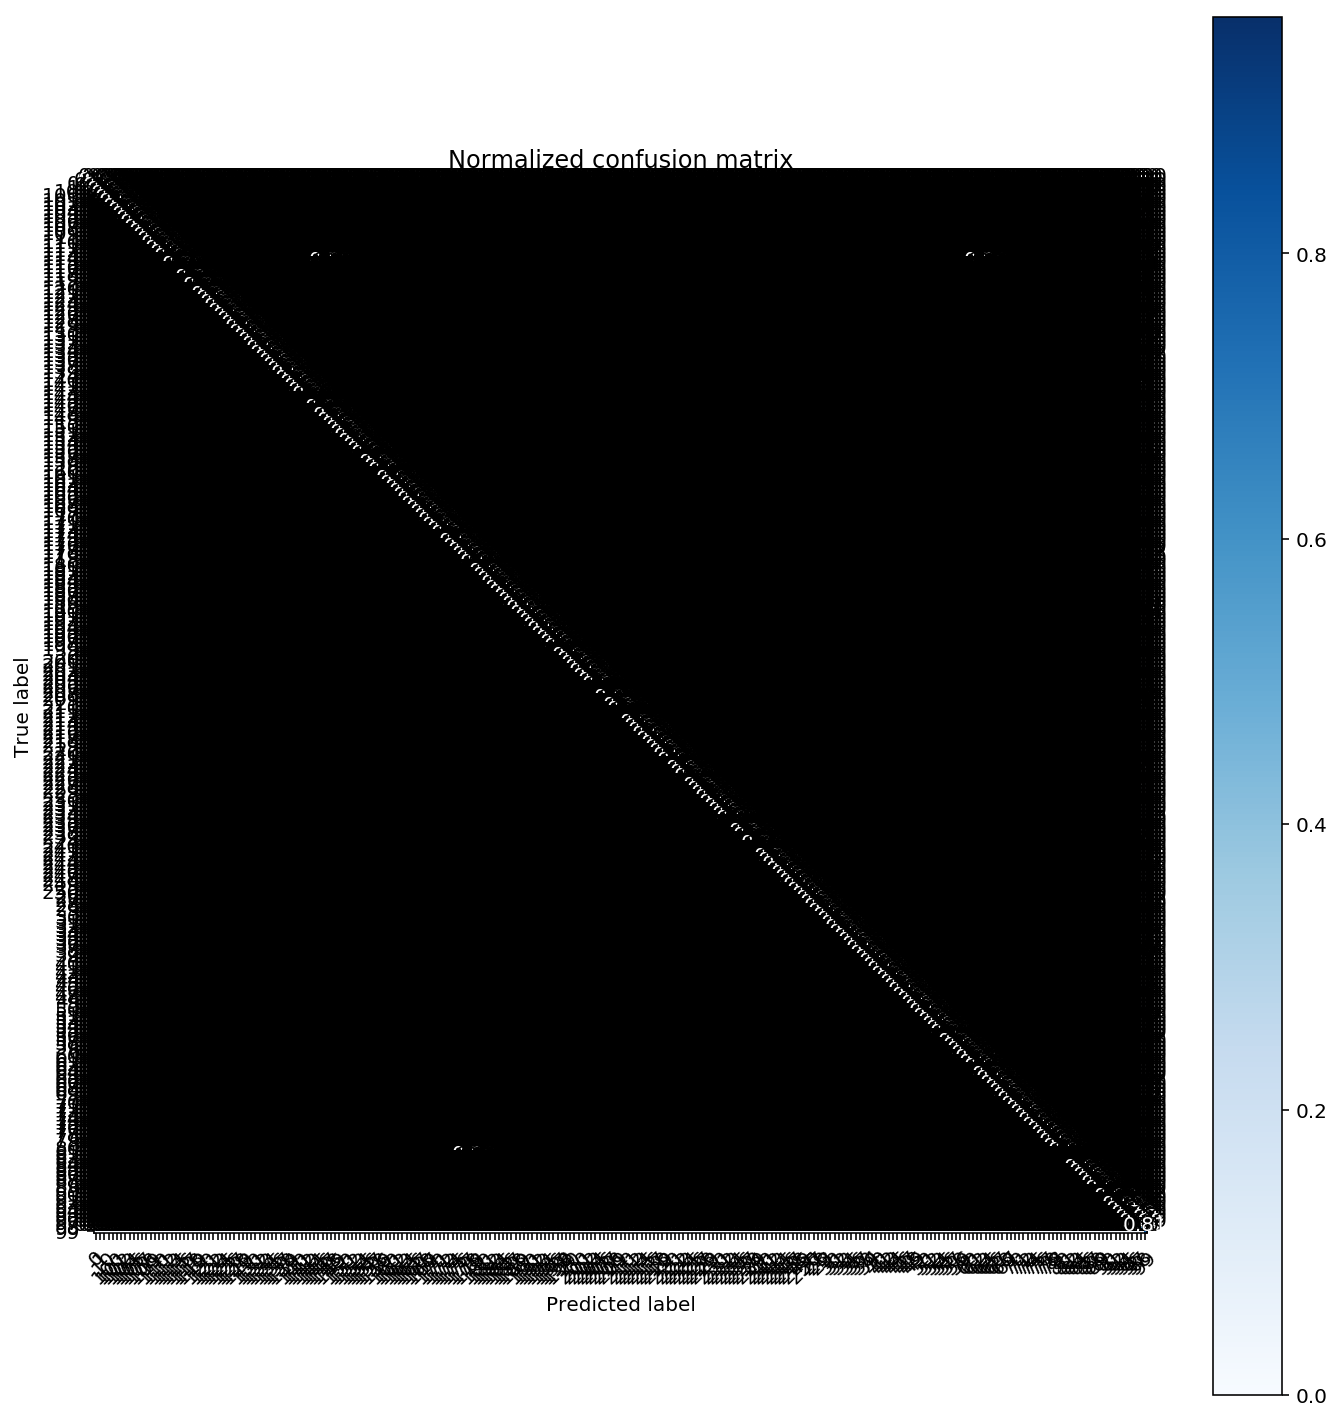

In [0]:
# compute predictions
predictions = model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

In [0]:
pred_true = 0
y_test2=val_labels.label.astype(int)
for i in range(len(y_pred)):
  print(y_pred[i],y_test[i])
  print(y_pred[i],y_test2[i])
  if(y_pred[i]==y_test2[i]):
    pred_true+=1
    
print("Suma: ",pred_true)
print("Accuracy: ",pred_true/len(y_pred))
class_names2=validation_generator.class_indices.values()

165 165
165 247
151 151
151 234
138 138
138 222
65 158
65 240
162 133
162 218
137 137
137 221
79 161
79 243
79 161
79 243
138 138
138 222
70 154
70 237
148 148
148 231
139 139
139 223
108 140
108 224
213 127
213 212
161 161
161 243
185 151
185 234
246 140
246 224
162 162
162 244
127 127
127 212
164 164
164 246
206 160
206 242
166 166
166 248
131 131
131 216
138 138
138 222
163 163
163 245
158 158
158 240
126 126
126 211
136 165
136 247
232 126
232 211
53 134
53 219
126 126
126 211
142 142
142 226
159 159
159 241
127 127
127 212
17 127
17 212
126 126
126 211
137 137
137 221
150 150
150 233
140 142
140 226
52 167
52 249
149 149
149 232
166 166
166 248
138 138
138 222
136 136
136 220
66 160
66 242
169 169
169 250
16 148
16 231
234 162
234 244
160 160
160 242
134 134
134 219
89 144
89 228
164 164
164 246
166 166
166 248
111 154
111 237
128 128
128 213
131 131
131 216
148 159
148 241
141 141
141 225
193 148
193 231
153 153
153 236
70 154
70 237
153 153
153 236
131 131
131 216
153 153
153 23

In [0]:
#Top1- scores
predicted_class_indices=np.argmax(pred_val,axis=1)
labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]


filenames=validation_generator.filenames
results=pd.DataFrame({"img_name":filenames,
                      "label":predictions})
results

,img_name,label
0,val_010323.jpg,247
1,val_010324.jpg,234
2,val_010325.jpg,222
3,val_010326.jpg,157
4,val_010327.jpg,244
5,val_010328.jpg,221
6,val_010329.jpg,17
7,val_010330.jpg,17
8,val_010331.jpg,222
9,val_010332.jpg,161


In [0]:
##############################################
# Prepare dataframe for validation generator #
##############################################
labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items()) # change order to proper (key,value) pair so value is now the label and key is value taken from generator
strings = list()
for i in range(pred_val.shape[0]):
#top1, top2, top3 are to top class indices from Keras generator that need to be converted to labels
  top1 = labels[pred_val[i].argsort()[-3:][::-1][0]] #pred[i].argsort()[-3:][::-1] gives top-3 predictions
  top2 = labels[pred_val[i].argsort()[-3:][::-1][1]]
  top3 = labels[pred_val[i].argsort()[-3:][::-1][2]]
  
  strings.append(top1+' '+top2+' '+top3)
  
submission = pd.DataFrame()
submission['img_name'] = validation_generator.filenames
submission['label'] = strings
#submission.to_csv("submission.csv", index=False)

submission
#!kaggle competitions submit -c ifood-2019-fgvc6 -f submission.csv -m "version 0.2"


,img_name,label
0,val_010323.jpg,247 156 2
1,val_010324.jpg,234 137 8
2,val_010325.jpg,222 228 122
3,val_010326.jpg,157 240 47
4,val_010327.jpg,244 173 195
5,val_010328.jpg,221 174 184
6,val_010329.jpg,17 167 243
7,val_010330.jpg,17 190 243
8,val_010331.jpg,222 228 47
9,val_010332.jpg,161 237 203


In [0]:
#Predict the output for test_generator
#You need to reset the test_generator before whenever you call the predict_generator. 
#This is important, if you forget to reset the test_generator you will get outputs in a weird order.
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()

pred_test=model.predict_generator(test_generator,
                             use_multiprocessing = False,
                             steps=STEP_SIZE_TEST,
                             verbose=1)



28377/28377 [==============================] - 1782s 63ms/step


In [0]:
predicted_class_indices=np.argmax(pred_test,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions

['212',
 '51',
 '234',
 '236',
 '231',
 '213',
 '233',
 '198',
 '195',
 '215',
 '222',
 '93',
 '245',
 '215',
 '216',
 '91',
 '42',
 '73',
 '245',
 '215',
 '93',
 '211',
 '230',
 '219',
 '218',
 '236',
 '226',
 '119',
 '127',
 '223',
 '220',
 '225',
 '241',
 '164',
 '197',
 '227',
 '217',
 '240',
 '246',
 '211',
 '54',
 '250',
 '246',
 '236',
 '213',
 '220',
 '182',
 '215',
 '231',
 '206',
 '236',
 '195',
 '240',
 '229',
 '244',
 '3',
 '236',
 '229',
 '219',
 '119',
 '214',
 '29',
 '223',
 '223',
 '240',
 '248',
 '214',
 '233',
 '224',
 '92',
 '213',
 '215',
 '250',
 '242',
 '47',
 '5',
 '237',
 '221',
 '248',
 '212',
 '36',
 '217',
 '245',
 '206',
 '245',
 '225',
 '225',
 '229',
 '249',
 '211',
 '47',
 '248',
 '1',
 '149',
 '241',
 '245',
 '233',
 '65',
 '229',
 '245',
 '235',
 '47',
 '226',
 '225',
 '236',
 '226',
 '231',
 '227',
 '250',
 '125',
 '229',
 '134',
 '225',
 '230',
 '212',
 '219',
 '72',
 '220',
 '222',
 '195',
 '244',
 '248',
 '240',
 '216',
 '77',
 '211',
 '230',
 '220'

In [0]:
##############################################
# Submission of results to kaggle server     #
##############################################
os.environ["KAGGLE_USERNAME"] = "technic2017"
os.environ["KAGGLE_KEY"] = "db6bd82821e7ecd01f6f83effc3cc41b"

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

strings = list()
for i in range(pred_test.shape[0]):
#top1, top2, top3 are to top class indices from Keras generator that need to be converted to labels
  top1 = labels[pred_test[i].argsort()[-3:][::-1][0]]#pred[i].argsort()[-3:][::-1] gives top-3 predictions
  top2 = labels[pred_test[i].argsort()[-3:][::-1][1]]
  top3 = labels[pred_test[i].argsort()[-3:][::-1][2]]
  
  strings.append(top1+' '+top2+' '+top3)
  
submission = pd.DataFrame()
submission['img_name'] = test_generator.filenames
submission['label'] = strings
submission.to_csv("submission.csv", index=False)

!cat submission.csv
!kaggle competitions submit -c ifood-2019-fgvc6 -f submission.csv -m "version 0.5"

img_name,label
test_024088.jpg,212 113 111
test_024089.jpg,51 232 106
test_024090.jpg,234 197 45
test_024091.jpg,236 144 31
test_024092.jpg,231 104 71
test_024093.jpg,213 246 176
test_024094.jpg,233 53 33
test_024095.jpg,198 171 55
test_024096.jpg,195 218 197
test_024097.jpg,215 93 240
test_024098.jpg,222 154 117
test_024099.jpg,93 249 215
test_024100.jpg,245 56 110
test_024101.jpg,215 93 47
test_024102.jpg,216 117 91
test_024103.jpg,91 216 200
test_024104.jpg,42 163 230
test_024105.jpg,73 2 238
test_024106.jpg,245 8 14
test_024107.jpg,215 93 249
test_024108.jpg,93 215 240
test_024109.jpg,211 231 103
test_024110.jpg,230 217 187
test_024111.jpg,219 146 203
test_024112.jpg,218 195 20
test_024113.jpg,236 219 146
test_024114.jpg,226 43 11
test_024115.jpg,119 247 161
test_024116.jpg,127 246 106
test_024117.jpg,223 146 5
test_024118.jpg,220 225 156
test_024119.jpg,225 115 188
test_024120.jpg,241 231 77
test_024121.jpg,164 175 249
test_024122.jpg,197 218 191
test_024123.jpg,227 119 48
test_02

In [0]:
###############################################################
# Loop through all files in given folder and make predictions #
###############################################################
from tensorflow.python.keras.applications.resnet50 import preprocess_input
#from tensorflow.python.keras.preprocessing import image
import glob
from skimage import transform

def get_files(path):
    if os.path.isdir(path):
        files = glob.glob(os.path.join(path, '*'))
    elif path.find('*') > 0:
        files = glob.glob(path)
    else:
        files = [path]

    #files = [f for f in files if f.endswith('JPG') or f.endswith('jpg')]
    if not len(files):
        sys.exit('No images found by the given path!')

    return files
  
def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (image_size, image_size, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image
  
  
def predict_all(model,img_dir):
    '''Predicts class based on the input image
       model - keras model
       img_dir - directory containing test images'''

    files = get_files(img_dir)
    font = {'family': 'serif',
        'color':  'white',
        'weight': 'normal',
        'size': 16,
        }


    for f in files:
      image = load(f)
      pred_image = model.predict(image)
      the_pred = np.argmax(pred_image)
      predicted = cat_to_name[the_pred]
      val_pred = np.max(pred_image)
      plt.title(('predicted: ' + predicted + ' | class id: ' + str(the_pred) + ' | Probability: [' + str(val_pred) + ']'), fontdict=font)
      plt.imshow(image[0])
      
    return 0
  
#predict_all(model,validation_dir)

[[ 80  68  18 226 146 174  14 220  72 159 171 157 133 240   1 170 148 103
  138 132  97  58 118 109 119 208 212  83 131 219 169 107 181  16 234 229
  248 250 112 136  17  87  64 123  40 100 101 218 188  57 223 135  41  60
   36 115  39 189 184  92 145  89 127 104 147 165  66  27 187 236 244 233
  139  95  98  78  84  90 124 158 166  49   7 102 120   6 204  55  62  54
  180  13 162 106 167 246 224 168   5  77 203  43 113 243 237 177  85 242
  205 195  22 211 151 144 140  30  31 197 130 202  75 210  33 230  44  37
   69 214  94 182  76 161  79 153   2 217 198  96 228  10  47 179 141  48
  149  86   9  73 232 215  12 216 222  46   0 213  26 172 176 190 156 175
  191 129  45  63  74 249   3  61 110  15  91  99 142 201  52 126  51 178
  207 152 114  81  59 231  11  21 160  28 105 196 143  93 227 150 155 193
   50  88  71  82  67 186  34 245 122 209  65  38 206  19 117   4 183 128
   56 163  29 108 192 116 137 134 121 125  35 164  32 200 185 241  23 235
   70 238 239 221 194  20  53 199 111 

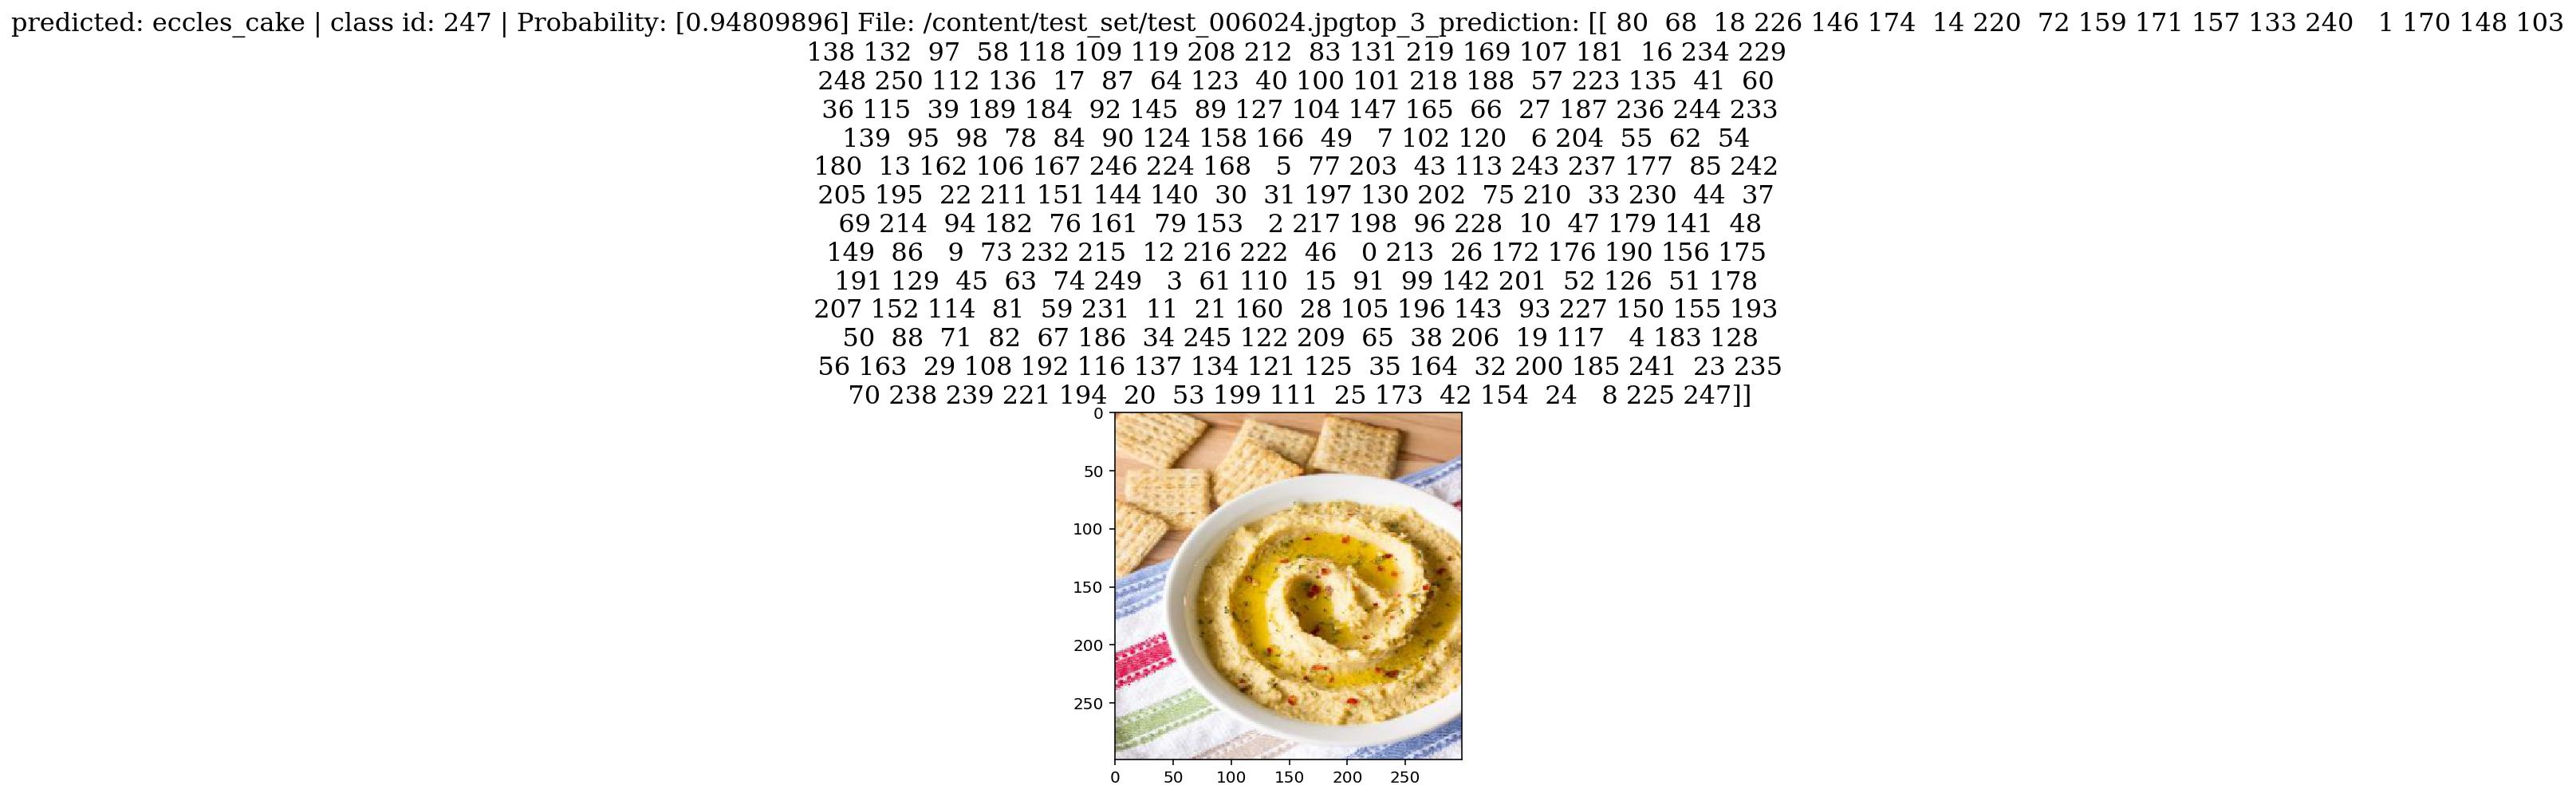

In [0]:
font = {'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
    }
files = get_files(test_dir)
f=1
image = load(files[f])
pred_image = model.predict(image)
the_pred = np.argmax(pred_image)
the_pred_top3 = pred_image.argsort()[-3:][::-1]
np.argpartition(pred_image, -4)[-4:]
predicted = cat_to_name[the_pred]
val_pred = np.max(pred_image)
plt.title(('predicted: ' + predicted + ' | class id: ' + str(the_pred) + ' | Probability: [' + str(val_pred) + ']' + ' File: ' + str(files[f]) + 'top_3_prediction: ' + str(the_pred_top3)), fontdict=font)
plt.imshow(image[0])
print(the_pred_top3)

pred:  [2.36e-07 2.79e-07 5.54e-07 7.29e-07 2.23e-07 1.02e-04 9.24e-06 6.16e-04
 1.22e-06 2.30e-06 4.79e-05 8.84e-06 8.55e-07 4.53e-07 7.20e-06 2.67e-06
 2.28e-07 2.26e-06 1.62e-06 6.17e-06 6.22e-06 1.69e-02 4.57e-05 9.48e-08
 1.39e-03 5.06e-07 1.10e-07 5.03e-02 1.07e-05 2.03e-06 7.15e-05 8.18e-07
 2.56e-06 5.96e-05 6.59e-04 5.74e-06 1.57e-05 5.96e-08 4.86e-04 4.53e-06
 1.87e-05 3.61e-07 4.59e-06 3.12e-06 2.46e-07 4.06e-06 1.85e-04 6.01e-05
 8.35e-06 1.39e-03 1.67e-05 1.13e-07 4.35e-04 2.38e-07 5.64e-03 2.30e-04
 1.35e-06 5.52e-07 9.49e-05 2.38e-03 7.45e-06 3.47e-07 1.67e-03 3.47e-09
 2.86e-07 2.78e-05 2.87e-03 4.83e-06 2.14e-04 1.97e-07 2.03e-07 3.24e-06
 4.75e-05 9.46e-06 3.40e-06 3.21e-06 1.18e-03 7.37e-06 8.57e-06 3.94e-04
 5.46e-04 1.84e-05 3.40e-08 1.93e-08 4.45e-06 2.73e-03 7.19e-06 5.18e-04
 2.60e-05 3.00e-06 7.19e-07 2.00e-03 1.19e-04 9.91e-05 1.96e-05 1.37e-07
 1.69e-06 1.91e-06 2.63e-05 4.54e-07 2.44e-05 1.62e-07 2.78e-04 8.30e-07
 4.10e-05 6.52e-06 4.11e-06 5.10e-04 3.38e-0

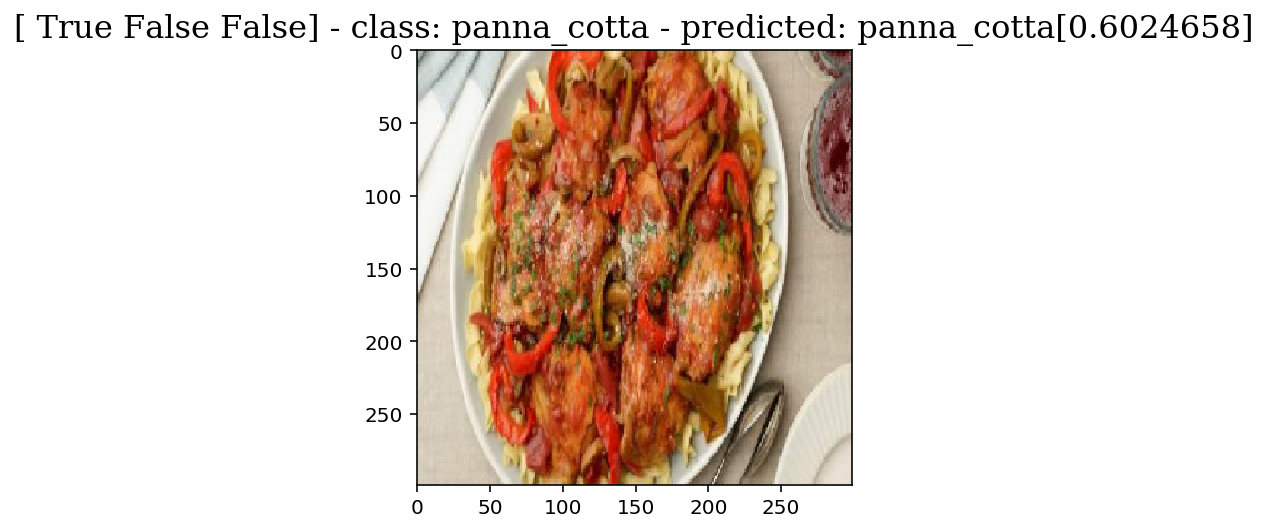

In [0]:
def predict_one(model,generator):
    font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

    image_batch, classes_batch = next(generator)
    predicted_batch = model.predict(image_batch)
    for k in range(1):
      image = image_batch[k]
      pred = predicted_batch[k]
      print("pred: ",pred)
      the_pred = np.argmax(pred)
      print("the_pred: ",the_pred)
      the_pred=pred.argsort()[-3:][::-1]
      print("the_pred_top_3: ",the_pred)
      print(validation_generator.filenames[k])
      predicted = cat_to_name[the_pred[0]]
      print("predicted: ",predicted)
      val_pred = max(pred)
      print("val_pred: ",val_pred)
      the_class = np.argmax(classes_batch[k])
      print("classes_batch[k]: ",classes_batch[k])
      print("the_class: ",the_class)
      value = cat_to_name[np.argmax(classes_batch[k])]
      print("value: ",value)
      plt.figure(k)
      isTrue = (the_pred == the_class)
      plt.title((str(isTrue) + ' - class: ' + value + ' - ' + 'predicted: ' + predicted + '[' + str(val_pred) + ']'), fontdict=font)
      plt.imshow(image)
predict_one(model, validation_generator)

In [0]:
#For each element print indexes of numpy array elements containing top-3 numbers with the highest value (top-3 accuracy)
#validation_generator.reset()
for i in range(pred.shape[0]):
  print(validation_generator.filenames[i])
  print(pred[i].argsort()[-3:][::-1]) 
  print('[' + cat_to_name[pred[i].argsort()[-3:][::-1][0]] + ' ' + cat_to_name[pred[i].argsort()[-3:][::-1][1]] + ' ' + cat_to_name[pred[i].argsort()[-3:][::-1][2]] + ']')
  

Number of true predictions:  0
Number of all predictions:  1
Accuracy:  0.0


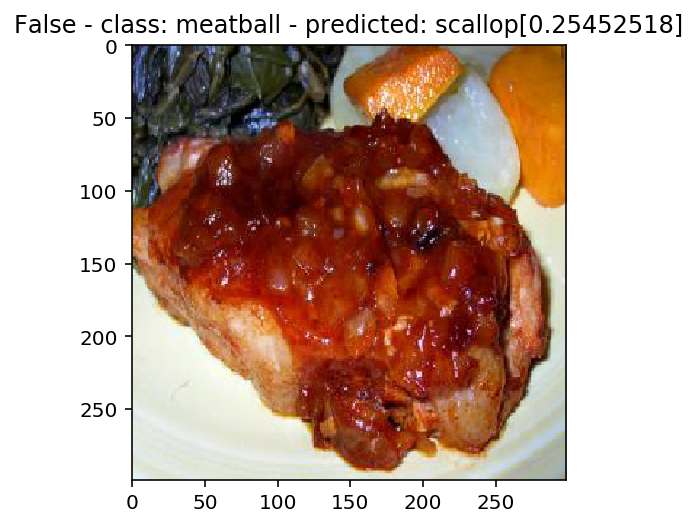

In [0]:
def predict_one(model,generator):
    labels = (generator.class_indices)
    labels = dict((v,k) for k,v in labels.items()) # change order to proper (key,value) pair so value is now the label and key is value taken from generator
    image_batch, classes_batch = next(generator)
    predicted_batch = model.predict(image_batch)
    true_pred=0
    all_pred=0
    for k in range(0,image_batch.shape[0]):
      image = image_batch[k]
      pred = predicted_batch[k]
      the_pred = np.argmax(pred)
      predicted = cat_to_name[the_pred]
      val_pred = max(pred)
      the_class = np.argmax(classes_batch[k])
      value = cat_to_name[np.argmax(classes_batch[k])]
      plt.figure(k)
      isTrue = (the_pred == the_class)
      if(isTrue): true_pred+=1
      all_pred+=1
      plt.title(str(isTrue) + ' - class: ' + value + ' - ' + 'predicted: ' + predicted + '[' + str(val_pred) + ']')
      plt.imshow(image)
    print('Number of true predictions: ',true_pred)
    print('Number of all predictions: ', all_pred)
    print('Accuracy: ', true_pred/all_pred)
    
predict_one(model,validation_generator)

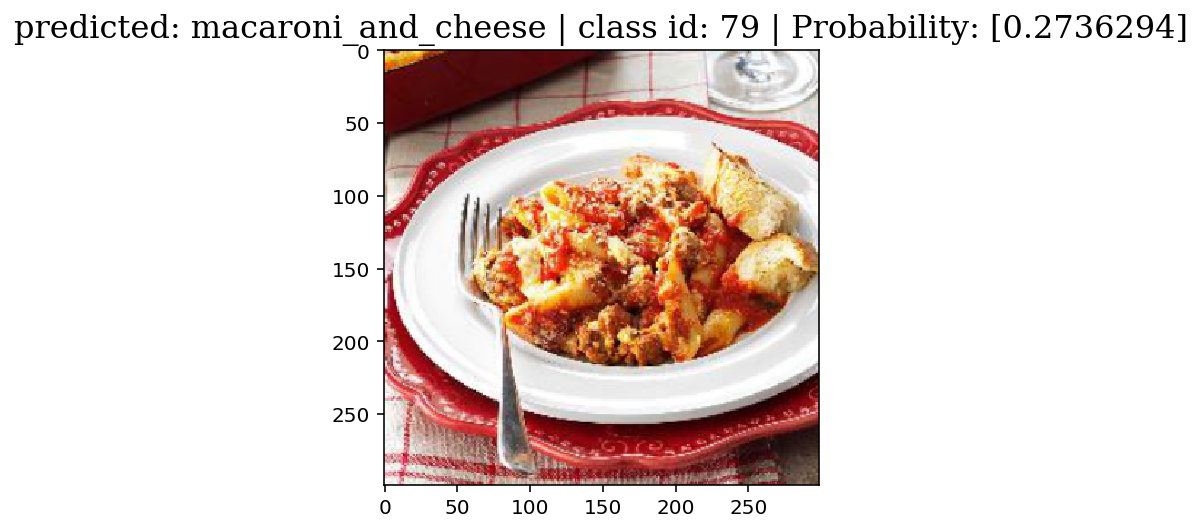

In [0]:
#Predict single image loaded from drive

from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (image_size, image_size, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load(os.path.join(validation_dir, 'val_010330.jpg'))
pred_image = model.predict(image)
the_pred = np.argmax(pred_image)
predicted = cat_to_name[the_pred]
val_pred = np.max(pred_image)
font = {'family': 'serif',
    'color':  'black',
    'weight': 'normal',
    'size': 16,
    }

plt.title(('predicted: ' + predicted + ' | class id: ' + str(the_pred) + ' | Probability: [' + str(val_pred) + ']'), fontdict=font)
plt.imshow(image[0])

In [0]:
np.max(pred_image)

In [0]:
cat_to_name

{0: 'macaron',
 1: 'beignet',
 2: 'cruller',
 3: 'cockle_food',
 4: 'samosa',
 5: 'tiramisu',
 6: 'tostada',
 7: 'moussaka',
 8: 'dumpling',
 9: 'sashimi',
 10: 'knish',
 11: 'croquette',
 12: 'couscous',
 13: 'porridge',
 14: 'stuffed_cabbage',
 15: 'seaweed_salad',
 16: 'chow_mein',
 17: 'rigatoni',
 18: 'beef_tartare',
 19: 'cannoli',
 20: 'foie_gras',
 21: 'cupcake',
 22: 'osso_buco',
 23: 'pad_thai',
 24: 'poutine',
 25: 'ramen',
 26: 'pulled_pork_sandwich',
 27: 'bibimbap',
 28: 'chicken_kiev',
 29: 'apple_pie',
 30: 'risotto',
 31: 'fruitcake',
 32: 'chop_suey',
 33: 'haggis',
 34: 'scrambled_eggs',
 35: 'frittata',
 36: 'scampi',
 37: 'sushi',
 38: 'orzo',
 39: 'fritter',
 40: 'nacho',
 41: 'beef_stroganoff',
 42: 'beef_wellington',
 43: 'spring_roll',
 44: 'savarin',
 45: 'crayfish_food',
 46: 'souffle',
 47: 'adobo',
 48: 'streusel',
 49: 'deviled_egg',
 50: 'escargot',
 51: 'club_sandwich',
 52: 'carrot_cake',
 53: 'falafel',
 54: 'farfalle',
 55: 'terrine',
 56: 'poached_eg

In [0]:
val_labels

,img_name,label
0,val_010323.jpg,247
1,val_010324.jpg,234
2,val_010325.jpg,222
3,val_010326.jpg,240
4,val_010327.jpg,218
5,val_010328.jpg,221
6,val_010329.jpg,243
7,val_010330.jpg,243
8,val_010331.jpg,222
9,val_010332.jpg,237
